# Imports

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from PIL import Image
from sklearn.decomposition import PCA

# Ratings

In [8]:
df = pd.read_csv(r"C:\Users\desus\OneDrive - Danmarks Tekniske Universitet\Fall_2025\Cognitive_Modelling\Kareninator\data\ratings\s243933_image_ratings.csv")

In [9]:
values = df['Rating'].tolist()
norm_values = [(x - min(values)) / (max(values) - min(values)) for x in values]

In [11]:
range(math.floor(min(norm_values)), math.ceil(max(norm_values) + 2))

range(0, 3)

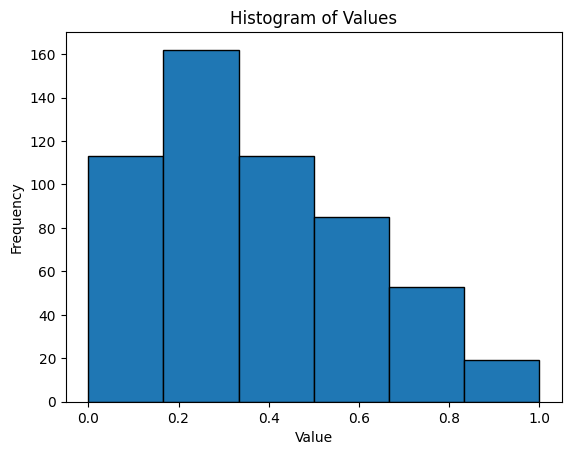

In [13]:
plt.hist(norm_values, 6, edgecolor="black")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Values")
plt.show()

# PCA

In [16]:
# Load images
image_folder = r"C:\Users\desus\OneDrive - Danmarks Tekniske Universitet\Fall_2025\Cognitive_Modelling\Kareninator\data\preprocessed_data"

In [ ]:
# Init matrix J
J = np.array([]).reshape(0, 100*100)  # Assuming images are 64x64 pixels

In [ ]:
# Add to matrix J -> each row is a flattened image
for img_file in os.listdir(image_folder):
    img = Image.open(os.path.join(image_folder, img_file))
    img_array = np.array(img).flatten()
    J = np.vstack([J, img_array])

In [ ]:
# Get the mean image and center the data
mean_J = np.mean(J)
J_centered = J - mean_J
J_centered

array([[-113.81331397, -107.81331397, -114.81331397, ...,   35.18668603,
          18.18668603,    8.18668603],
       [ -85.81331397,  -88.81331397,  -92.81331397, ..., -128.81331397,
        -128.81331397, -129.81331397],
       [ -62.81331397,  -75.81331397,  -85.81331397, ...,  -28.81331397,
         -75.81331397, -114.81331397],
       ...,
       [ -70.81331397,  -74.81331397,  -85.81331397, ...,  -34.81331397,
         -38.81331397,  -39.81331397],
       [ -36.81331397,  -53.81331397,  -73.81331397, ...,  -76.81331397,
         -91.81331397,  -88.81331397],
       [-110.81331397, -114.81331397, -118.81331397, ...,   99.18668603,
          98.18668603,   97.18668603]])

In [40]:
# Do PCA on the centered data
pca = PCA(n_components=100)
J_pca = pca.fit_transform(J_centered)

Text(0, 0.5, 'Cumulative Explained Variance')

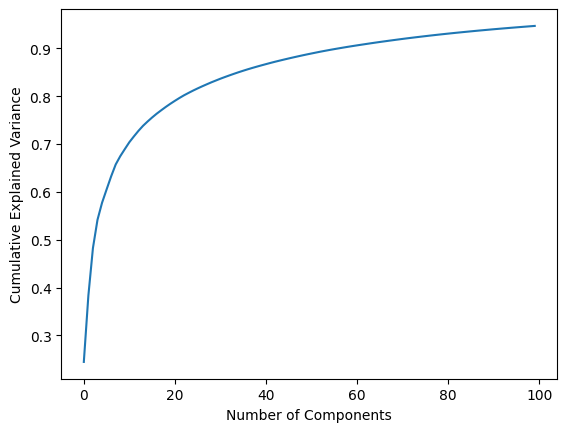

In [42]:
# Plot cumulative explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')